In [1]:
from dptb.nn.build import build_model
from dptb.postprocess.bandstructure.band import Band
import  matplotlib.pyplot  as plt
import numpy as np
from ase.io import read
from dptb.data import AtomicData, AtomicDataDict
from dptb.nn.nnsk import NNSK
import json
import torch

In [3]:
model = NNSK.from_reference(checkpoint= "./model/v2ckpt.json")

In [4]:
stru_data = "./data/silicon.vasp"
structase = read(stru_data)
AtomicData_options = {"r_max": 2.6, "oer_max":2.5, "pbc": True}
data = AtomicData.from_ase(structase, **AtomicData_options)
data = AtomicData.to_AtomicDataDict(data)
data = model.idp(data)

In [5]:
#set the band structure task
jdata={   
    "task_options": {
        "task": "band",
        "kline_type":"abacus",
        "kpath":[[0.0000000000,  0.0000000000,   0.0000000000,   50],   
                [0.5000000000,   0.0000000000,   0.5000000000,   50],               
                [0.6250000000,   0.2500000000,   0.6250000000,   1],    
                [0.3750000000,   0.3750000000,   0.7500000000,   50],     
                [0.0000000000,   0.0000000000,   0.0000000000,   50],    
                [0.5000000000,   0.5000000000,   0.5000000000,   50],                
                [0.5000000000,   0.2500000000,   0.7500000000,   50],               
                [0.5000000000,   0.0000000000,   0.5000000000,   1 ]
                ],
        "klabels":["G","X","X/U","K","G","L","W","X"],
        "E_fermi":-9.307,
        "emin":-15,
        "emax":10,
        "ref_band": "./data/kpath.0/eigenvalues.npy"
    }
}

In [6]:
# calculate the band structure
kpath_kwargs = jdata["task_options"]
bcal = Band(model=model, 
            use_gui=True, 
            results_path='./', 
            device=model.device)

stru_data = "./data/silicon.vasp"
AtomicData_options = {"r_max": 2.6, "oer_max":2.5, "pbc": True}

eigenstatus = bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs, 
               AtomicData_options=AtomicData_options)

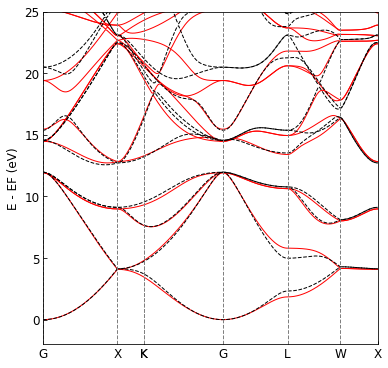

In [7]:
# plot the band structure w.r.t. DFT results
band = np.load(f'./data/kpath.0/eigenvalues.npy')
if len(band.shape)==3:
    band = band[0,:,:]
plt.figure(figsize=(6,6),dpi=72)
plt.plot(eigenstatus['xlist'], eigenstatus['eigenvalues']- np.min(eigenstatus['eigenvalues']), 'r-',lw=1)
plt.plot(eigenstatus['xlist'], band[:,:] - np.min(band[:,:]),'k--',lw=1)
plt.ylim(-2,25)

for ii in eigenstatus['high_sym_kpoints']:
    plt.axvline(ii,color='gray',lw=1,ls='--')
plt.tick_params(direction='in')

plt.xlim(eigenstatus['xlist'].min(),eigenstatus['xlist'].max())

plt.ylabel('E - EF (eV)',fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(eigenstatus['high_sym_kpoints'], eigenstatus['labels'], fontsize=12)
#plt.savefig(f'{self.results_path}/band.png',dpi=300)
plt.show()